# Scikit-learn 내장 데이터셋: load_digits (손글씨 숫자 분류)

이 노트북은 Scikit-learn에서 제공하는 손글씨 숫자 데이터셋을 사용하여 데이터를 시각화하고, 다양한 머신러닝 모델을 통해 숫자를 분류하는 과정을 담고 있습니다.

## 데이터셋 설명 (Dataset Description)

- **데이터셋 이름**: Optical Recognition of Handwritten Digits Data
- **데이터 개수**: 1,797개
- **특성 개수**: 64개 (8x8 픽셀 이미지 데이터)
- **클래스 개수**: 10개 (0부터 9까지의 숫자)
- **데이터 내용**: 각 이미지는 0-16 범위를 갖는 정수 픽셀 데이터로 구성되어 있습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드 및 분석 (EDA)

In [2]:
digits = load_digits()
print(f"Data keys: {digits.keys()}")
print(f"Data shape: {digits.data.shape}")
print(f"Target classes: {np.unique(digits.target)}")

# 데이터프레임 변환
df = pd.DataFrame(digits.data)
df['target'] = digits.target

df.head()

Data keys: dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
Data shape: (1797, 64)
Target classes: [0 1 2 3 4 5 6 7 8 9]


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [3]:
# 'target'별로 데이터셋의 갯수를 확인
df['target'].value_counts().sort_values()

target
8    174
2    177
0    178
7    179
9    180
4    181
6    181
1    182
5    182
3    183
Name: count, dtype: int64

## 2. 데이터 시각화

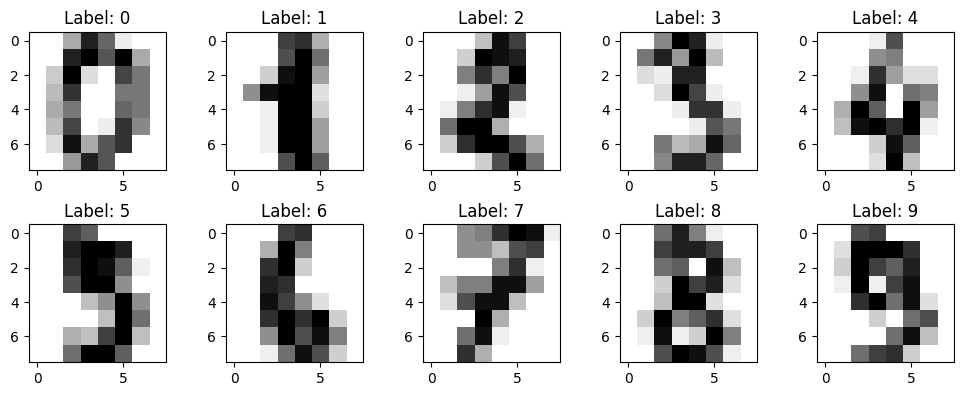

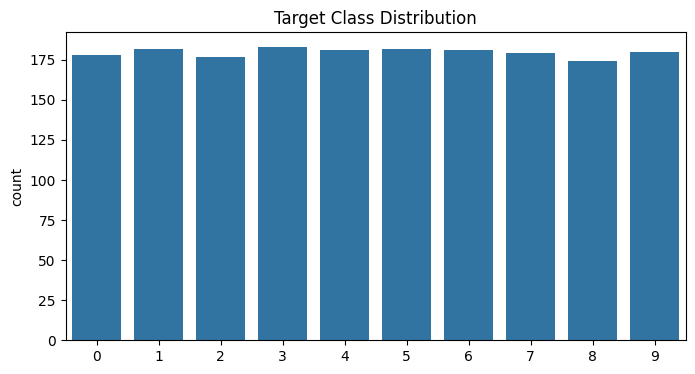

In [4]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 4))
for index, (image, label) in enumerate(zip(digits.images[:10], digits.target[:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Label: {label}')
plt.tight_layout()
plt.show()

# 클래스별 데이터 분포 확인
plt.figure(figsize=(8, 4))
sns.countplot(x=digits.target)
plt.title('Target Class Distribution')
plt.show()

## 3. 데이터 전처리 및 학습/테스트 데이터 분리

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [6]:
X = digits.data
y = digits.target

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
scaled_df = pd.DataFrame(data=X_scaled, columns=df.columns.drop('target'))
scaled_df.describe().round(4)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,...,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000,1797.0000
mean,0.0,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,...,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
std,0.0,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,...,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003
min,0.0,-0.3350,-1.0949,-2.7864,-2.7642,-1.0207,-0.4097,-0.1250,-0.0591,-0.6240,...,-0.7574,-0.2098,-0.0236,-0.2991,-1.0894,-2.7642,-2.3941,-1.1466,-0.5057,-0.1960
25%,0.0,-0.3350,-0.8846,-0.4322,-0.4312,-1.0207,-0.4097,-0.1250,-0.0591,-0.6240,...,-0.7574,-0.2098,-0.0236,-0.2991,-0.8934,-0.2490,-0.3668,-1.1466,-0.5057,-0.1960
50%,0.0,-0.3350,-0.2535,0.2741,0.2688,-0.3145,-0.4097,-0.1250,-0.0591,-0.6240,...,-0.5541,-0.2098,-0.0236,-0.2991,-0.3053,0.2083,0.4442,-0.1295,-0.5057,-0.1960
75%,0.0,-0.3350,0.7984,0.7449,0.7354,0.9211,-0.4097,-0.1250,-0.0591,0.3149,...,0.6659,-0.2098,-0.0236,-0.2991,0.8708,0.8942,0.8496,0.8876,-0.0166,-0.1960
max,0.0,8.4859,2.2710,0.9803,0.9687,1.8038,4.4025,14.3385,21.1734,4.3834,...,2.4959,12.9999,42.3792,9.3365,2.0469,0.8942,0.8496,1.5657,3.4069,8.4080


In [10]:
# 학습/테스트 데이터 분리(80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1437, 64)
X_test shape: (360, 64)


In [16]:
# y_train의 레이블별 데이터 갯수 세기
unique, counts = np.unique(y, return_counts=True)
print(counts)
unique, counts = np.unique(y_train, return_counts=True)
print(counts)
unique, counts = np.unique(y_test, return_counts=True)
print(counts)

[178 182 177 183 181 182 181 179 174 180]
[142 146 142 146 145 145 145 143 139 144]
[36 36 35 37 36 37 36 36 35 36]


## 4. 모델링 (6가지 모델)

In [17]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# 성능 기준 정렬
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
top_4_models = [item[0] for item in sorted_results[:4]]
print(f"\nTop 4 Models for Ensemble: {top_4_models}")

LogisticRegression Accuracy: 0.9722
RandomForest Accuracy: 0.9611
SVM Accuracy: 0.9750
KNN Accuracy: 0.9667
GradientBoosting Accuracy: 0.9556
ExtraTrees Accuracy: 0.9750

Top 4 Models for Ensemble: ['SVM', 'ExtraTrees', 'LogisticRegression', 'KNN']


## 5. 하이퍼 파라메터 튜닝 및 앙상블 모델 생성

성능이 좋게 나온 상위 4개 모델을 사용하여 소프트 보팅 앙상블을 만듭니다.

In [18]:
# 예시로 SVM 과 RandomForest 튜닝 진행 (실제 환경에 맞게 조정 가능)
param_grid_svc = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(probability=True), param_grid_svc, cv=3)
grid_svc.fit(X_train, y_train)

param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3)
grid_rf.fit(X_train, y_train)

# 상위 4개 모델로 앙상블 구성 (여기서는 튜닝된 파라메터 적용 예시)
estimators = []
if 'SVM' in top_4_models: estimators.append(('svc', grid_svc.best_estimator_))
if 'RandomForest' in top_4_models: estimators.append(('rf', grid_rf.best_estimator_))
if 'LogisticRegression' in top_4_models: estimators.append(('lr', LogisticRegression(max_iter=1000)))
if 'KNN' in top_4_models: estimators.append(('knn', KNeighborsClassifier()))
if 'ExtraTrees' in top_4_models: estimators.append(('et', ExtraTreesClassifier(random_state=42)))
if 'GradientBoosting' in top_4_models: estimators.append(('gb', GradientBoostingClassifier(random_state=42)))

# 상위 4개만 유지되도록 보정 루틴 (중복 방지 및 상위 4개 선정)
ensemble_model = VotingClassifier(estimators=estimators[:4], voting='soft')
ensemble_model.fit(X_train, y_train)

ensemble_pred = ensemble_model.predict(X_test)
print(f"Ensemble Model Accuracy: {accuracy_score(y_test, ensemble_pred):.4f}")

Ensemble Model Accuracy: 0.9833


## 6. 모델 평가

### Confusion Matrix ###


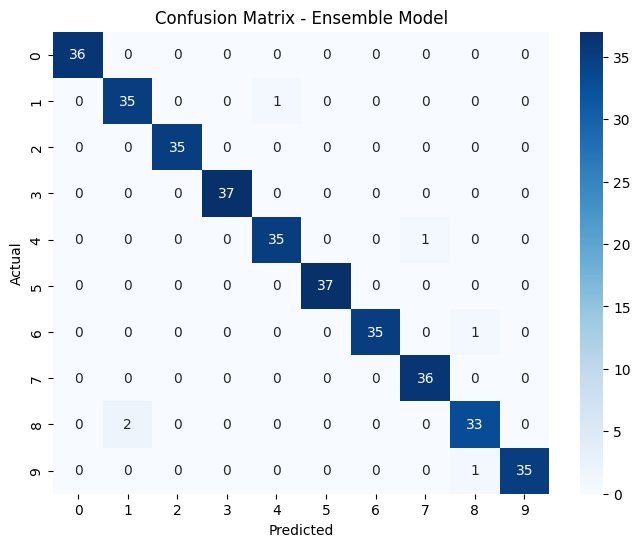


### Classification Report ###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      0.97      0.97        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.94      0.94      0.94        35
           9       1.00      0.97      0.99        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



In [19]:
print("### Confusion Matrix ###")
cm = confusion_matrix(y_test, ensemble_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

print("\n### Classification Report ###")
print(classification_report(y_test, ensemble_pred))